# Projeto: Classificação de Fake News Utilizando o Dataset WELFake

Este projeto utiliza o dataset WELFake para realizar a classificação de notícias falsas utilizando técnicas de processamento de linguagem natural (NLP) e aprendizado de máquina. O modelo principal utilizado é o Support Vector Machine (SVM), que será treinado utilizando o vetorizador TF-IDF para transformar os textos em representações numéricas. Além disso, foi explorada a análise de tópicos usando LDA.

---

## Bibliotecas Utilizadas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import re

## Carregamento e Inspeção dos Dados
Aqui carregamos os dados e realizamos uma inspeção inicial para entender o formato e o conteúdo do dataset.

In [ ]:
# Load the data
data_raw = pd.read_csv('../data/WELFake_Dataset.csv')
data = data_raw.copy()

# Visualizar os primeiros registros
data.head()

## Informações e Estatísticas Iniciais
Analisamos as informações sobre as colunas do dataset, identificando os tipos de dados e a presença de valores nulos.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [5]:
data.isna().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

## Distribuição dos Rótulos (Fake News vs Real News)
Verificamos a distribuição dos rótulos no dataset.

In [6]:
data.label.value_counts()

label
1    37106
0    35028
Name: count, dtype: int64

## Limpeza e Preprocessamento dos Dados
Removemos colunas desnecessárias e tratamos os valores ausentes.

In [7]:
data.drop('Unnamed: 0',axis=1,inplace=True)

# Substituindo valores NaN nas colunas 'title' e 'text' por strings vazias
data['title'] = data['title'].fillna('')
data['text'] = data['text'].fillna('')

data['combined_text'] = data['title'] + ' ' + data['text']

Realizamos o preprocessamento do texto, incluindo a remoção de stopwords, tokenização e lematização.

In [9]:
# Inicializando o lemmatizer e definindo as stopwords
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(stemmer.stem(token)) for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

# Aplicando a função de preprocessamento ao texto
data['combined_text'] = data['combined_text'].apply(preprocess_text)

## Divisão dos Dados em Conjuntos de Treino e Teste
Dividimos os dados em conjuntos de treino e teste com uma proporção de 80/20.

In [ ]:
# Dividindo os dados em treino e teste
X = data['combined_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Vetorização do Texto com TF-IDF
Utilizamos o TF-IDF para transformar o texto em uma matriz numérica

In [ ]:
# Inicializando o vetorizador TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Treinamento do Classificador SVM
Treinamos o modelo SVM para realizar a classificação das notícias.

In [81]:
# Treinar um classificador (SVM)
clf = SVC(kernel='linear', class_weight='balanced')
clf.fit(X_train_tfidf, y_train)

# Avaliar o classificador
y_pred = clf.predict(X_test_tfidf)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

Balanced Accuracy: 0.9583


## Análise dos Coeficientes do Modelo
Exibimos as palavras mais importantes (com maiores coeficientes) no modelo SVM.

In [82]:
# Obter os nomes das features (palavras) do TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Obter os coeficientes do classificador
coefficients = clf.coef_.toarray()

# Para um classificador binário, clf.coef_ terá apenas uma linha
# Obter os índices das palavras
positive_indices = np.argsort(coefficients[0])[::-1][:5]  # Top 5 positivos
negative_indices = np.argsort(coefficients[0])[:5]  # Top 5 negativos

# Exibir as palavras mais importantes e seus respectivos coeficientes
print("Top 5 palavras com maior coeficiente positivo:")
for i in positive_indices:
    print(f"{feature_names[i]}: {coefficients[0, i]:.4f}")

print("\nTop 5 palavras com menor coeficiente negativo:")
for i in negative_indices:
    print(f"{feature_names[i]}: {coefficients[0, i]:.4f}")


Top 5 palavras com maior coeficiente positivo:
via: 15.5107
imag: 9.6154
video: 5.4752
octob: 5.4620
hillari: 4.6484

Top 5 palavras com menor coeficiente negativo:
reuter: -22.4815
000: -10.9173
breitbart: -10.2780
said: -8.9144
twitter: -6.7402


## Impacto do Tamanho do Dataset no Desempenho
Testamos diferentes tamanhos de amostras para verificar o impacto no desempenho do modelo.

In [10]:
def compare_size(X, y, amostras_size=0.1):
    amostra = int(len(X) * amostras_size)
    
    if amostras_size == 1.0:
        X_amostra, y_amostra = X, y
    else:
        X_amostra, _, y_amostra, _ = train_test_split(X, y, train_size=amostra, stratify=y, random_state=42)
        
    
    X_train, X_test, y_train, y_test = train_test_split(X_amostra, y_amostra, test_size=0.3, random_state=42)
    
    tdidf_vectorizer = TfidfVectorizer()

    X_train_tfidf = tdidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tdidf_vectorizer.transform(X_test)
    
    clf = SVC(kernel='linear', class_weight='balanced')
    clf.fit(X_train_tfidf, y_train)
    
    train_error = 1 - balanced_accuracy_score(y_train, clf.predict(X_train_tfidf))
    balanced_accuracy = balanced_accuracy_score(y_test, clf.predict(X_test_tfidf))
    test_error = 1 - balanced_accuracy
    return train_error, test_error, balanced_accuracy

amostras = [0.1, 0.25, 0.5, 0.75, 1.0]
accuracies = []
train_errors = []
test_errors = []

for amostra in amostras:
    train_error, test_error, accuracy = compare_size(X, y, amostra)
    train_errors.append(train_error)
    test_errors.append(test_error)
    accuracies.append(accuracy)

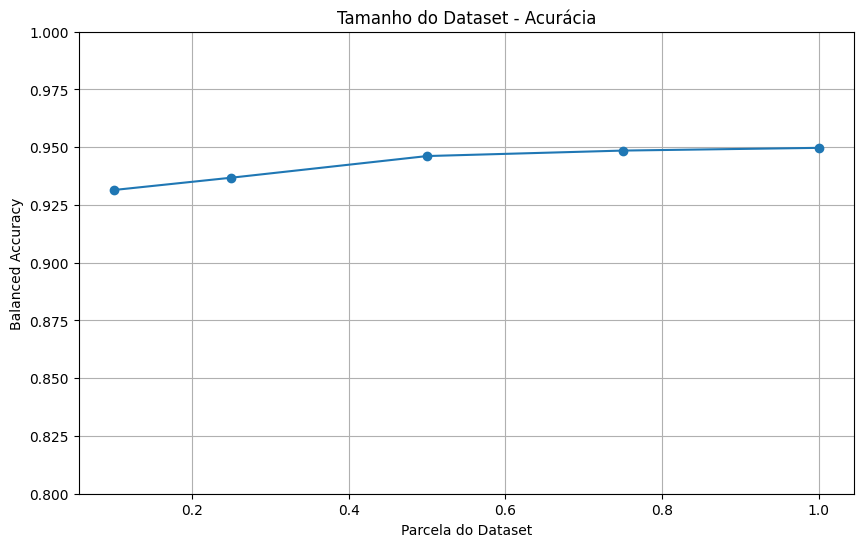

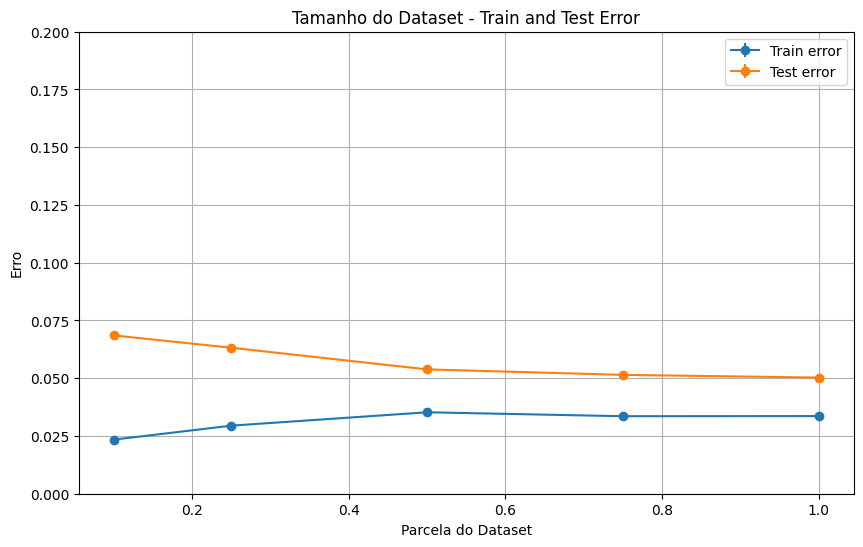

In [12]:
plt.figure(figsize=(10, 6))
plt.errorbar(amostras, accuracies, fmt='-o')
plt.title('Tamanho do Dataset - Acurácia')
plt.xlabel('Parcela do Dataset')
plt.ylabel('Balanced Accuracy')
plt.ylim(0.8, 1)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(amostras, train_errors, fmt='-o', label='Train error')
plt.errorbar(amostras, test_errors, fmt='-o', label='Test error')
plt.title('Tamanho do Dataset - Train and Test Error')
plt.xlabel('Parcela do Dataset')
plt.ylabel('Erro')
plt.ylim(0, 0.2)
plt.legend()
plt.grid(True)
plt.show()

## Análise de Tópicos com LDA
Aplicamos LDA para identificar tópicos principais no dataset e associar as notícias aos tópicos.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vetorização do texto
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
X_vectorized = vectorizer.fit_transform(data['combined_text'])

# Definindo o número de tópicos e ajustando o modelo LDA
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_vectorized)

# Exibir os principais tópicos
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Tópico {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Exibir as 10 palavras principais de cada tópico
no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)

Tópico 0:
said united government state states military president china reuters north
Tópico 1:
said mr trump court police law president state new people
Tópico 2:
people like new said just time years world year life
Tópico 3:
trump said clinton republican new house state president party election
Tópico 4:
trump president hillary clinton people donald just news like media


## Atribuição de tópicos aos documentos
Cada documento foi atribuído a um tópico com base na maior probabilidade de associação ao tema.

In [21]:
# Atribuir um tópico a cada documento com base na probabilidade mais alta
document_topics = lda.transform(X_vectorized)
data['dominant_topic'] = document_topics.argmax(axis=1)

## Avaliação por tópico
Classificadores SVM separados foram treinados para cada tópico, avaliando a acurácia para os documentos de cada tópico individualmente.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

topic_accuracies = []

# Para cada tópico, treinar um classificador separado
for topic in data['dominant_topic'].unique():
    # Filtrar os dados por tópico
    topic_data = data[data['dominant_topic'] == topic]
    X_topic = topic_data['combined_text']
    y_topic = topic_data['label']
    
    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_topic, y_topic, test_size=0.2, random_state=42)
    
    # Vetorização TF-IDF
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Treinando um classificador (usando SVM como exemplo)
    clf = SVC(kernel='linear', class_weight='balanced')
    clf.fit(X_train_tfidf, y_train)
    
    # Previsões e avaliação
    y_pred = clf.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    topic_accuracies.append((topic, accuracy))
    
    print(f"Tópico {topic}: Acurácia = {accuracy:.4f}")


Tópico 4: Acurácia = 0.9565
Tópico 1: Acurácia = 0.9481
Tópico 0: Acurácia = 0.9590
Tópico 3: Acurácia = 0.9339
Tópico 2: Acurácia = 0.9346


Referência: P. K. Verma, P. Agrawal, I. Amorim, and R. Prodan, ``WELFake: Word Embedding Over Linguistic Features for Fake News Detection,'' IEEE Transactions on Computational Social Systems, vol. 8, no. 4, pp. 881–893, 2021. doi:10.1109/TCSS.2021.3068519.